In [ ]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from tools import utils
from data import goes16s3

import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import os
from PIL import Image


# Hurricane Michael

In [ ]:
dayofyear = 283
year = 2018
n_channels = 8
image_group = 'images-hurricane-michael-10102018/'

## Download Data

In [ ]:
noaa = goes16s3.NOAAGOESS3(channels=range(1,n_channels+1), product='ABI-L1b-RadC')
noaa.download_day(year, dayofyear)

In [10]:
def goes_8band_image(da):
    cmaps = ['Blues', 'Reds'] + ['gnuplot2']*5 + ['jet']
    tempdir = 'figures/tmp/'
    if not os.path.exists(tempdir):
        os.makedirs(tempdir)
        
    image_files = []
    for c in range(8):
        imgfile = os.path.join(tempdir, 'img_%02i.png' % (c+1))
        #plt.imsave(imgfile, da[c], cmap=cmaps[c], vmin=0, vmax=1.0)
        image_files.append(imgfile)
        
    images = map(Image.open, image_files)   
    widths, heights = zip(*(i.size for i in images))
    
    total_height = heights[0]*3
    total_width = widths[0]*3
    
    new_im = Image.new('RGB', (total_width, total_height))
    x_offset = 0
    y_offset = 0
    for i, im in enumerate(images):
        if i == 3:
            x_offset = 0
            y_offset = heights[0]
        elif i == 6:
            x_offset = int(widths[i]/2)
            y_offset = heights[0] * 2
        
        new_im.paste(im, (x_offset, y_offset))
        x_offset += widths[i]
        
    new_im.save('figures/8band.jpg')
        
    
    #[os.remove(i) for i in image_files]
    
def add_timestamp_to_image(img_file, img_date):
    datestr = img_date.strftime("%m/%d/%Y %H:%M")
    cmd = 'convert %s -gravity northwest -pointsize 32 -fill white -annotate +30+30  "%s" %s' % (img_file, datestr, img_file)
    return os.system(cmd)

files = noaa.local_files()

dayfiles = files.loc[year, dayofyear].values
row = dayfiles[dayfiles.shape[0]/2]
rad = goes16s3._open_and_merge_2km(row[:8])
goes_8band_image(rad)

In [ ]:
def goes_16band_image(da):
    cmaps = ['Blues', 'Reds'] + ['gnuplot2']*5 + ['jet']*9
    tempdir = 'figures/tmp2/'
    if not os.path.exists(tempdir):
        os.makedirs(tempdir)
        
    image_files = []
    for c in range(16):
        imgfile = os.path.join(tempdir, 'img_%02i.png' % (c+1))
        plt.imsave(imgfile, da[c], cmap=cmaps[c], vmin=0, vmax=1.0)
        image_files.append(imgfile)
        
    images = map(Image.open, image_files)   
    widths, heights = zip(*(i.size for i in images))
    
    total_height = heights[0]*4
    total_width = widths[0]*4
    
    new_im = Image.new('RGB', (total_width, total_height))
    x_offset = 0
    y_offset = 0
    for i, im in enumerate(images):
        if (i != 0) and (i % 4 == 0):
            x_offset = 0
            y_offset += heights[0]
        
        new_im.paste(im, (x_offset, y_offset))
        x_offset += widths[i]
        
    new_im.save('figures/16band.jpg')
        
        
    #[os.remove(i) for i in image_files]

files = noaa.local_files()

dayfiles = files.loc[year, dayofyear].values
row = dayfiles[dayfiles.shape[0]/2]
rad = goes16s3._open_and_merge_2km(row[:16])
goes_16band_image(rad)
#
print(row)


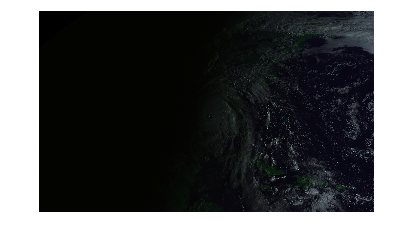

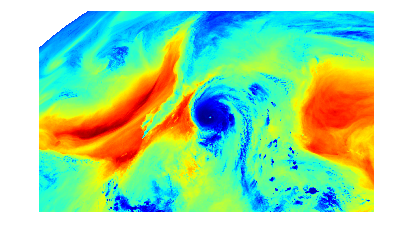

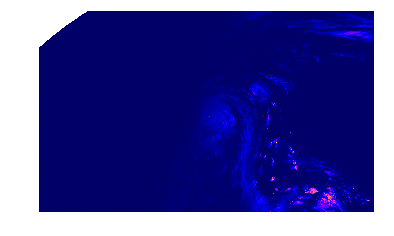

In [19]:
rgbfiles = row[:3]
radrgb = goes16s3._open_and_merge_2km(rgbfiles)
rgb = np.transpose(radrgb.values[[1,2,0]], (1,2,0))
plt.imshow(rgb, vmin=0.0, vmax=1.)
plt.axis('off')
plt.show()

# water vapor
wvfile = [row[7]]
wvrad = goes16s3._open_and_merge_2km(wvfile)
plt.imshow(wvrad.values[0], cmap='jet')
plt.axis('off')
plt.show()

#
wvfile = [row[3]]
wvrad = goes16s3._open_and_merge_2km(wvfile)
wvimg = wvrad.values[0]
plt.imshow(wvimg, cmap='gnuplot2', vmin=-0.1)
plt.axis('off')
plt.show()

In [ ]:
images = []
image_path = image_group + 'original-resolution/'
wv_image_path = image_group + 'original-watervapor-upper/'

if not os.path.exists(image_path):
    os.makedirs(image_path)
    
if not os.path.exists(wv_image_path):
    os.makedirs(wv_image_path)
    

    
img_counter = 0
for i, row in files.loc[year, dayofyear].iterrows():
    rowfiles = row.values[:n_channels]
    rad = goes16s3._open_and_merge_2km(rowfiles)
    #rgb = np.transpose(rad.values[[1,2,0]], (1,2,0))
    wv = rad.values[7]
    
    image_file = image_path + 'img-%05i.png' % img_counter
    wv_file = wv_image_path + 'img-%05i.png' % img_counter
    images.append(image_file)
    #plt.imsave(images[-1], rgb)

    plt.imsave(wv_file, wv)#, cmap='jet')
    
    hour, minute, _, _ = row.name
    imgdate = datetime.datetime(year, 1, 1) + datetime.timedelta(dayofyear - 1, hours=hour, minutes=minute)
    
    #add_timestamp_to_image(image_file, imgdate)
    add_timestamp_to_image(wv_file, imgdate)
    
    img_counter += 1


In [ ]:
fps = 16
video_file = os.path.join(image_path, 'video-%02dFPS.mp4' % fps)
if os.path.exists(video_file):
    os.remove(video_file)
    
cmd = 'ffmpeg -r {} -i {}/img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {}'.format(fps, image_path, video_file)
os.system(cmd)




In [ ]:
# Make Water vapor video
wv_video_file = os.path.join(wv_image_path, 'video-%02dFPS.mp4' % fps)
if os.path.exists(wv_video_file):
    os.remove(wv_video_file)
    
cmd = 'ffmpeg -r {} -i {}/img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {}'.format(fps, wv_image_path, wv_video_file)
os.system(cmd)

In [7]:
from tools import inference_tools

model_path = '../saved-models/5Min-%iChannels/' % n_channels
flownet, interpnet, warper = inference_tools.load_models(n_channels, model_path, True)

/home/tj/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


loading checkpoint ../saved-models/5Min-8Channels/checkpoint.flownet.mv.pth.tar
=> loaded checkpoint '../saved-models/5Min-8Channels/checkpoint.flownet.mv.pth.tar' (epoch 19)


In [8]:
image_group

'images-hurricane-michael-10102018/'

In [53]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def inference_5min(X0, X1, flownet, interpnet, warper, 
                   multivariate, T=4, block_size=None):
    '''
    Given two consecutive frames, interpolation T between them 
        using flownet and interpnet
    Returns:
        Interpolated Frames
    '''
    
    X0_arr_torch = torch.from_numpy(X0.values)
    X1_arr_torch = torch.from_numpy(X1.values)

    # nans to 0
    X0_arr_torch[np.isnan(X0_arr_torch)] = 0.
    X1_arr_torch[np.isnan(X1_arr_torch)] = 0.
    
    X0_arr_torch = torch.unsqueeze(X0_arr_torch, 0).to(device)
    X1_arr_torch = torch.unsqueeze(X1_arr_torch, 0).to(device)

    f = flownet(X0_arr_torch, X1_arr_torch)
    n_channels = X0_arr_torch.shape[1]
        
    if multivariate:
        f_01 = f[:,:2*n_channels]
        f_10 = f[:,2*n_channels:]
    else:
        f_01 = f[:,:2]
        f_10 = f[:,2:]
        
    predicted_frames = []
    
    for j in range(1,T+1):
        t = 1. * j / (T+1)
        I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1 = interpnet(X0_arr_torch, X1_arr_torch, f_01, f_10, t)
        predicted_frames.append(I_t.cpu().detach().numpy())

    torch.cuda.empty_cache()
    return predicted_frames
    
def inference_5min_conus(X0, X1, flownet, interpnet, warper, 
                   multivariate, T=4, block_size=None):
    '''
    Given two consecutive frames, interpolation T between them 
        using flownet and interpnet
    Returns:
        Interpolated Frames
    '''
    # Get a list of dataarrays chunked
    X0_blocks = utils.blocks(X0, width=2*352)
    X1_blocks = utils.blocks(X1, width=2*352)

    interpolated_blocks = []
    for x0, x1 in zip(X0_blocks, X1_blocks):
        predicted_frames = inference_5min(x0, x1, flownet, 
                                          interpnet, warper,
                                          multivariate, T, 
                                          block_size)
        predicted_frames = [x0.values[np.newaxis]] + predicted_frames + [x1.values[np.newaxis]]
        interpolated_blocks += [inference_tools.block_predictions_to_dataarray(predicted_frames, x0)]
    return inference_tools.merge_and_average_dataarrays(interpolated_blocks)


X0 = None
X1 = None
T = 4

image_path = image_group + '1minute-resolution-sub/'
if not os.path.exists(image_path):
    os.makedirs(image_path)

wv_image_path = image_group + '1minute-watervapor-upper-sub/'
if not os.path.exists(wv_image_path):
    os.makedirs(wv_image_path)
    
images = []
img_counter = 0
X0 = None
for i, row in files.loc[year, dayofyear].iterrows():
    fs = row.values[:n_channels]
    X1 = goes16s3._open_and_merge_2km(fs)
    if X0 is not None:
        XT = inference_5min_conus(X0, X1, flownet, interpnet, warper, True,
                       T=T, block_size=None)
        for i in range(T+1):
            rgb = np.transpose(XT.values[i][[1,2,0]], (1,2,0))
            images.append(image_path + 'img-%05i.png' % img_counter)
            #plt.imsave(images[-1], rgb[::-1])
            wvimg_file = wv_image_path + 'img-%05i.png' % img_counter
            plt.imsave(wvimg_file, XT.values[i][7][::-1])
            img_counter += 1
            
            hour, minute, _, _ = row.name
            minute = minute + 5*i/(T+1)
            imgdate = datetime.datetime(year, 1, 1) + datetime.timedelta(dayofyear - 1, hours=hour, minutes=minute)
            #add_timestamp_to_image(images[-1], imgdate)
            add_timestamp_to_image(wvimg_file, imgdate)
        
    X0 = X1


KeyboardInterrupt: 

In [ ]:
#make_video('images-hurricane-michael-10102018/original-watervapor-upper/', fps=16)
make_video('images-hurricane-michael-10102018/1minute-watervapor-upper-sub/', fps=16)
make_video('images-hurricane-michael-10102018/1minute-watervapor-upper-sub/', fps=80)


In [24]:
def make_video(image_path, fps=80):
    video_file = os.path.join(image_path, 'video-%02dFPS.mp4' % fps)
    if os.path.exists(video_file):
        os.remove(video_file)

    cmd = 'ffmpeg -r {} -i {}/img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {}'.format(fps, image_path, video_file)
    print(cmd)
    os.system(cmd)

make_video('images-hurricane-michael-10102018/1minute-watervapor-upper/', fps=16)
make_video('images-hurricane-michael-10102018/1minute-watervapor-upper/', fps=80)

ffmpeg -r 16 -i images-hurricane-michael-10102018/1minute-watervapor-upper//img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p images-hurricane-michael-10102018/1minute-watervapor-upper/video-16FPS.mp4
ffmpeg -r 80 -i images-hurricane-michael-10102018/1minute-watervapor-upper//img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p images-hurricane-michael-10102018/1minute-watervapor-upper/video-80FPS.mp4


ffmpeg -r 16 -i images-hurricane-michael-10102018/1minute-watervapor-upper-sub//img-%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p images-hurricane-michael-10102018/1minute-watervapor-upper-sub/video-16FPS.mp4


In [45]:
ximg = X1.isel(y=slice(250,1000), x=slice(1000,1700))
ximg.sel(band=8).plot()

IndexError: index -1 is out of bounds for axis 0 with size 0